# Building Micrograd

## What is Micrograd?
Micrograd is a tiny Autograd (automatic gradient) engine, which implements backpropagation.

Backpropagation allows you to efficiently evaluate the gradient of a loss function with respect to the weights of a neural network. Can iteratively tune weights of the neural network to minimize the loss function and improve the accuracy.

Micrograd only works on scalars. This would not be in production since you need to parallelize with tensors. The underlying math though is the same, so this is used for pedagogical reasons.

The actual code to make neural nets in micrograd work is only ~150 lines among two different files!

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3 * x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

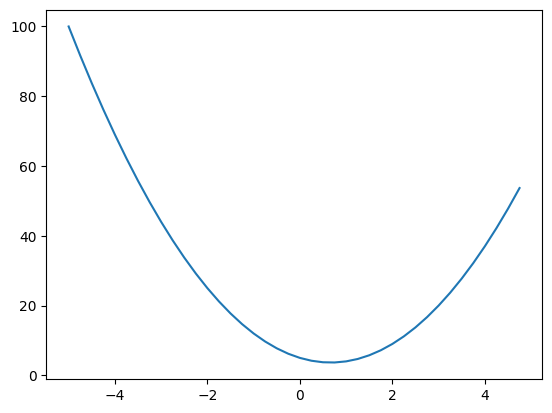

In [6]:
plt.plot(xs, ys)

We want to work with the derivative, but in neural nets, no one actually writes out the derivative. It would take too long and have many thousands of terms. Instead, we use the definition of the derivative (change in response divided by a small change in input)

In [7]:
h = 0.000000000001
x = 3.0
(f(x+h) - f(x)) / h


14.001244608152774

In [8]:
h = 0.000000000001
x = -3.0
(f(x+h) - f(x)) / h


-21.9984030991327

In [9]:
h = 0.000000000001
x = 2/3
(f(x+h) - f(x)) / h


-0.0004440892098500626

Floating point precision affects these numbers, but they should be 14, -22, and 0

In [10]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [11]:
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0

# dd/da
d1 = a*b + c
a += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2-d1)/h)

d1:  4.0
d2:  3.997
slope:  -3.0000000000001137


In [12]:
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0

# dd/db
d1 = a*b + c
b += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2-d1)/h)

d1:  4.0
d2:  4.002
slope:  1.9999999999997797


In [13]:
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0

# dd/dc
d1 = a*b + c
c += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2-d1)/h)

d1:  4.0
d2:  4.0009999999999994
slope:  0.9999999999994458


In [14]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other **-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [15]:
a1 = Value(2.0)
b1 = Value(4.0)
a1 - b1

Value(data=-2.0)

In [16]:
a = Value(2.0, label='a')
a

Value(data=2.0)

In [17]:
b = Value(-3.0, label='b')
b

Value(data=-3.0)

In [18]:
a + b

Value(data=-1.0)

In [19]:
a*b

Value(data=-6.0)

In [20]:
c = Value(10.0, label='c')
a*b+c

Value(data=4.0)

In [21]:
e = a*b; e.label = 'e'

In [22]:
# d = a*b + c
d = e + c; d.label = 'd'
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [23]:
d._op

'+'

In [24]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s |  data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

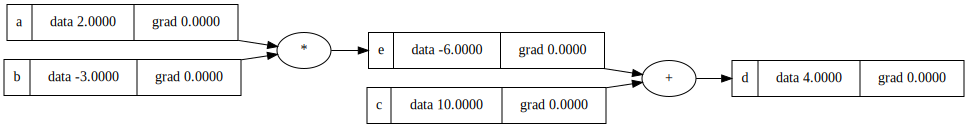

In [25]:
draw_dot(d)

In [26]:
f = Value(-2.0, label='f')
L = d * f; L.label="L"
L

Value(data=-8.0)

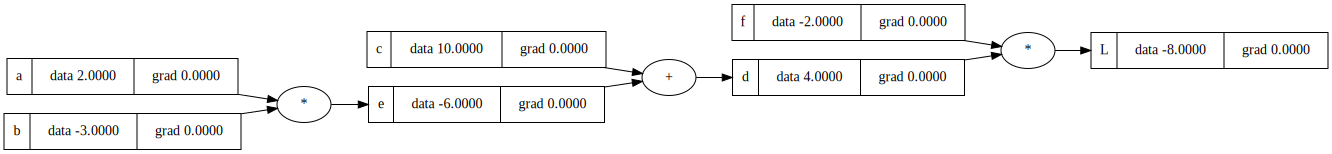

In [27]:
draw_dot(L)

In [28]:
def lol():

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label="L"
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label="L"
    L2 = L.data

    print((L2 - L1)/h)

lol()

0.0


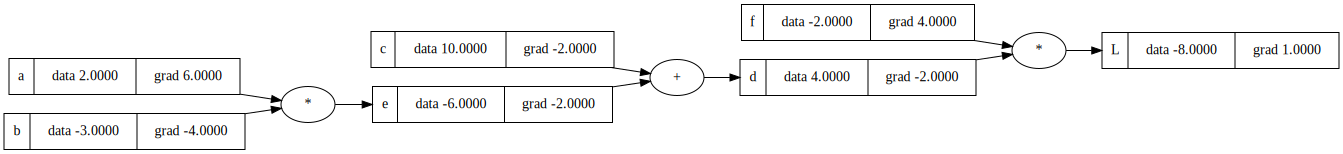

In [29]:
L.grad = 1
f.grad = 4.0
d.grad = -2.0

# used chain rule in the lecture to determine the following
c.grad = -2.0
e.grad = -2.0

# same, more chain rule
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

draw_dot(L)

In [30]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-7.286496


### Going to a more complicated example: neurons

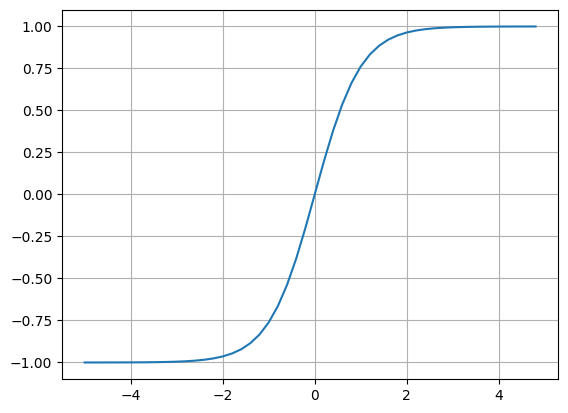

In [31]:
# neurons usually use some sort of activation/squashing function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Notice tanh() caps values to -1 and 1 here

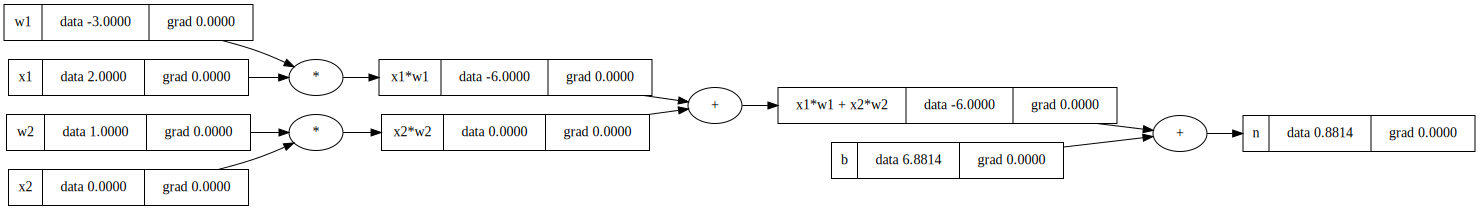

In [32]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias  of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)

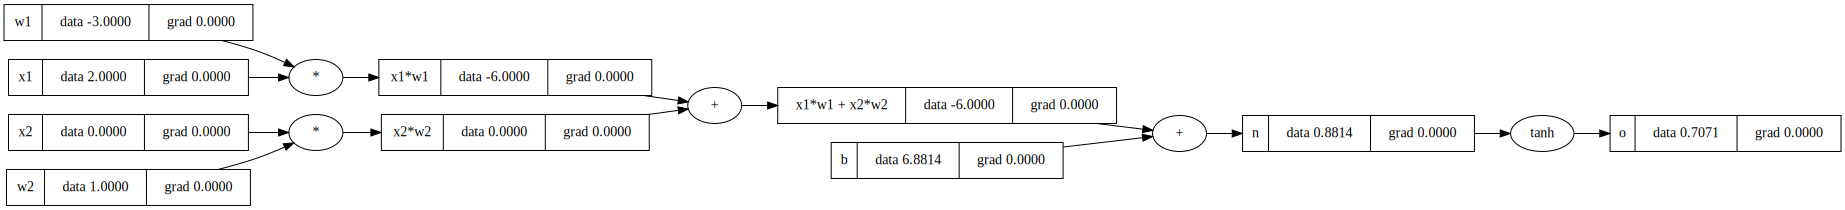

In [33]:
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [34]:
# # do/do
# o.grad = 1.0

# # do/dn
# # o = tanh(n)
# # do / dn = 1 - (tanh(n))**2 = 1 - o**2
# n.grad = 0.5

# b.grad = 0.5
# x1w1x2w2.grad = 0.5

# x1w1.grad = 0.5
# x2w2.grad = 0.5

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# draw_dot(o)

In [35]:
# o.grad = 1.0
# o._backward()

In [36]:
# draw_dot(o)

In [37]:
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()
# x1._backward()
# x2._backward()
# w1._backward()
# w2._backward()
# draw_dot(o)

In [38]:
# o.grad = 1.0

# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# for node in reversed(topo):
#     node._backward()

# draw_dot(o)


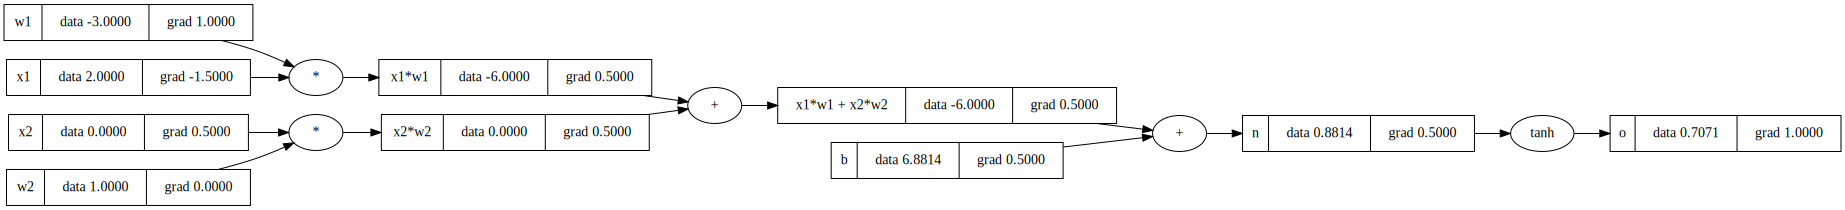

In [39]:
o.backward()
draw_dot(o)

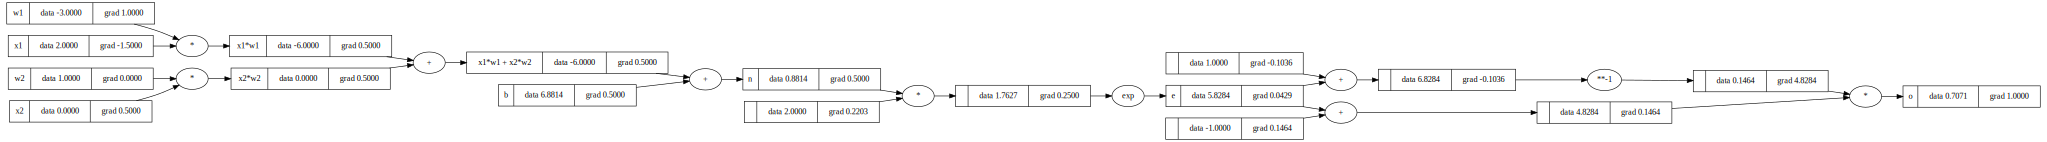

In [40]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias  of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp(); e.label = 'e'
o = (e-1)/(e+1)
o.label = 'o'
o.backward()
draw_dot(o)

In [41]:
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-' * 50)
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
--------------------------------------------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [42]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [59]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
        
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [91]:
x = [2.0, 3.0, -1.0]
# n = Neuron(2)
# n = Layer(2, 3)
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7846867357278647)

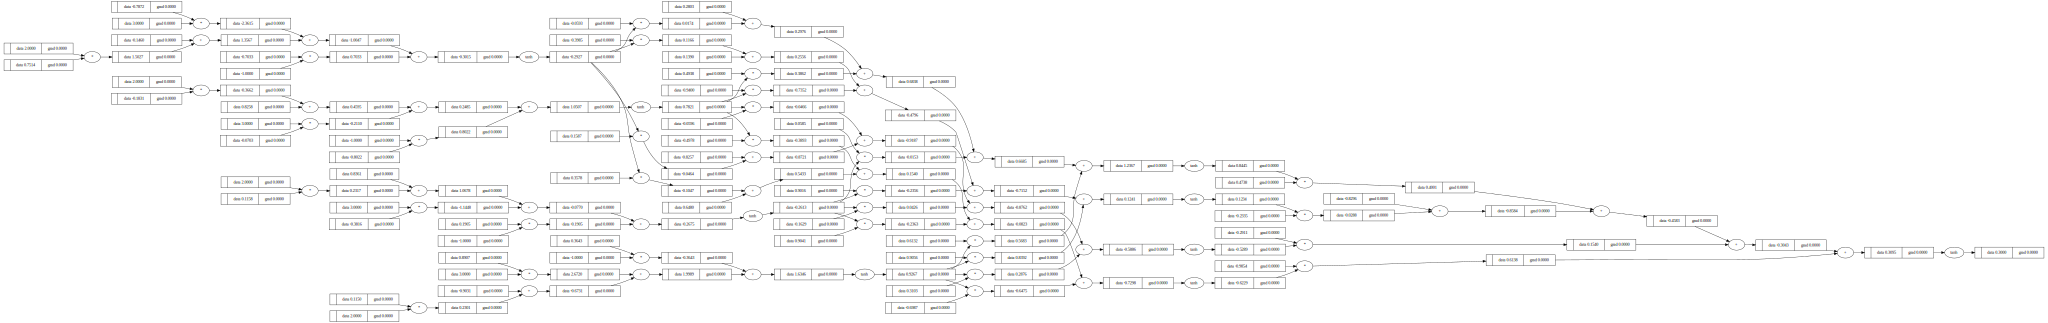

In [61]:
draw_dot(n(x))

In [62]:
n.parameters()

[Value(data=0.7513629005425604),
 Value(data=-0.7871581493020776),
 Value(data=-0.7032807211677099),
 Value(data=-0.14599969795605916),
 Value(data=-0.1831196398827175),
 Value(data=-0.07033823401137718),
 Value(data=-0.8022042723562572),
 Value(data=0.8257736150967154),
 Value(data=0.1158349449822722),
 Value(data=-0.38159430346871104),
 Value(data=0.19051377947440518),
 Value(data=0.8360855186596718),
 Value(data=0.11503576327303855),
 Value(data=0.8906553404608801),
 Value(data=0.3643436077888622),
 Value(data=-0.9031239121725971),
 Value(data=-0.39850197679859045),
 Value(data=-0.9400468956131651),
 Value(data=0.9015835523641536),
 Value(data=0.9056120611564802),
 Value(data=0.1390057666139306),
 Value(data=-0.05930219515909485),
 Value(data=0.4937525991389067),
 Value(data=0.05850085373994229),
 Value(data=0.6131981894536567),
 Value(data=0.2802637369915375),
 Value(data=0.15867102855495197),
 Value(data=-0.05957306612341462),
 Value(data=-0.1628631037737278),
 Value(data=0.310296

In [78]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypreds = [n(x) for x in xs]
ypreds

[Value(data=-0.6876055961252799),
 Value(data=-0.2882672786555029),
 Value(data=-0.5759478080433309),
 Value(data=-0.5793096985078492)]

In [79]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypreds)])
loss


Value(data=6.028615500010014)

In [80]:
loss.backward()

In [66]:
n.layers[0].neurons[0].w[0].grad

0.5865160349794387

In [67]:
n.layers[0].neurons[0].w[0].data

0.7513629005425604

In [81]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [82]:
ypreds = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypreds)])
loss

Value(data=5.139931588178953)

In [83]:
loss.backward()
loss

Value(data=5.139931588178953)

In [88]:
for p in n.parameters():
    p.data += -0.01 * p.grad
ypreds = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypreds)])
loss.backward()
loss

Value(data=0.5678470488109654)

In [89]:
ypreds

[Value(data=0.9070364178761593),
 Value(data=-0.9132403834396913),
 Value(data=-0.26747696343607313),
 Value(data=0.8771684444161783)]

In [92]:
for k in range(20):

    # forward pass
    ypreds = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypreds)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 4.6434764848873025
1 1.6646094421976556
2 0.9102154796388143
3 0.5235059117125302
4 0.3364148428591125
5 0.2374549487673153
6 0.17932173386969977
7 0.14211135600182612
8 0.11666494651588871
9 0.09835565585376788
10 0.08464767144364305
11 0.07405439711933069
12 0.06565480385461517
13 0.05885158662516399
14 0.053242305772480895
15 0.04854691999659969
16 0.04456511030784288
17 0.041150131965950035
18 0.03819223343388054
19 0.035607821721432314


In [93]:
ypreds

[Value(data=0.9108789475035272),
 Value(data=-0.9053214539660244),
 Value(data=-0.9055692652501193),
 Value(data=0.901085547169065)]